# ECF Performance Analysis

Raw data was generated using the `../src/EncryptedContainerFile/ECF.Test.Profiling` C#-project.

In [1]:
from brokenaxes import brokenaxes
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scienceplots
from tqdm import tqdm

plt.style.use(['science', 'grid', 'ieee'])

In [2]:
# Load data

def get_test_path(base_path):
    return os.path.basename(base_path)[:-4]

def get_test_name(test_path):
    return test_path.replace('_Decrypt', '') \
                    .replace('_Encrypt', '')


def get_run_name(base_path):
    return os.path.basename(base_path)

def get_run_friendly_name(run_name):
    return {
        'Ryzen 7 PRO 6850U net7': 'AMD Ryzen 7 6850U running .NET 7.0',
        'Ryzen 7 PRO 6850U net8': 'AMD Ryzen 7 6850U running .NET 8.0',
        'Ryzen 7 7900X net8': 'AMD Ryzen 7 7900X running .NET 8.0',
    }[run_name]

def get_run_table_name(run_name):
    return {
        'Ryzen 7 PRO 6850U net7': 'R7 6850U (.NET 7.0)',
        'Ryzen 7 PRO 6850U net8': 'R7 6850U (.NET 8.0)',
        'Ryzen 7 7900X net8': 'R7 7900X (.NET 8.0)',
    }[run_name]

def get_cipher_suite_name(base_name):
    cs_name = base_name.replace('ECF.Core.Container.CS', '')
    return cs_name
    return {
        'X25519Ed25519AesGcmSha256': 'Cipher Suite I',
        'X25519Ed25519AesGcmSha512': 'Cipher Suite II',
        'X25519Ed25519AegisSha256': 'Cipher Suite III',
        'X25519Ed25519AegisSha512': 'Cipher Suite IV',
    }[cs_name]

def get_cipher_suite_latex(base_name):
    return {
        'X25519Ed25519AesGcmSha256': r'\ref{e:cip:x25519-ed25519-aes256gcm-sha256}',
        'X25519Ed25519AesGcmSha512': r'\ref{e:cip:x25519-ed25519-aes256gcm-sha512}',
        'X25519Ed25519AegisSha256': r'\ref{e:cip:x25519-ed25519-aegis256-sha256}',
        'X25519Ed25519AegisSha512': r'\ref{e:cip:x25519-ed25519-aegis256-sha512}',
    }[base_name]

def load_csv(path):
    df = pd.read_csv(path, index_col=-1)
    df.columns = [get_cipher_suite_name(col) for col in df.columns]
    return df


performance_runs = glob('./data/*')
results = {
    get_test_name(test): {
        get_run_name(run): load_csv(f'{run}/{test}.csv')
        for run in performance_runs
    }
    for test in sorted(map(get_test_path, glob(os.path.join(performance_runs[0], '*.csv'))))
}

cipher_suites = []
performance_runs = [get_run_name(run) for run in performance_runs]


for test, runs in results.items():
    for run, result in runs.items():
        print(f'{run:23} {test:34} {result.shape[0]}')
        for cipher_suite in result.columns:
            if cipher_suite not in cipher_suites:
                cipher_suites.append(cipher_suite)

print(f'Found {len(cipher_suites)} cipher suites: {cipher_suites}')

Ryzen 7 PRO 6850U net7  Decrypt(1000MB, n=5, True, True)   10
Ryzen 7 PRO 6850U net8  Decrypt(1000MB, n=5, True, True)   10
Ryzen 7 7900X net8      Decrypt(1000MB, n=5, True, True)   10
Ryzen 7 PRO 6850U net7  Decrypt(100MB, n=5, True, True)    50
Ryzen 7 PRO 6850U net8  Decrypt(100MB, n=5, True, True)    50
Ryzen 7 7900X net8      Decrypt(100MB, n=5, True, True)    50
Ryzen 7 PRO 6850U net7  Decrypt(10MB, n=5, True, True)     100
Ryzen 7 PRO 6850U net8  Decrypt(10MB, n=5, True, True)     100
Ryzen 7 7900X net8      Decrypt(10MB, n=5, True, True)     100
Ryzen 7 PRO 6850U net7  Decrypt(1MB, n=10, False, True)    100
Ryzen 7 PRO 6850U net8  Decrypt(1MB, n=10, False, True)    100
Ryzen 7 7900X net8      Decrypt(1MB, n=10, False, True)    100
Ryzen 7 PRO 6850U net7  Decrypt(1MB, n=10, True, False)    100
Ryzen 7 PRO 6850U net8  Decrypt(1MB, n=10, True, False)    100
Ryzen 7 7900X net8      Decrypt(1MB, n=10, True, False)    100
Ryzen 7 PRO 6850U net7  Decrypt(1MB, n=10, True, True)     10

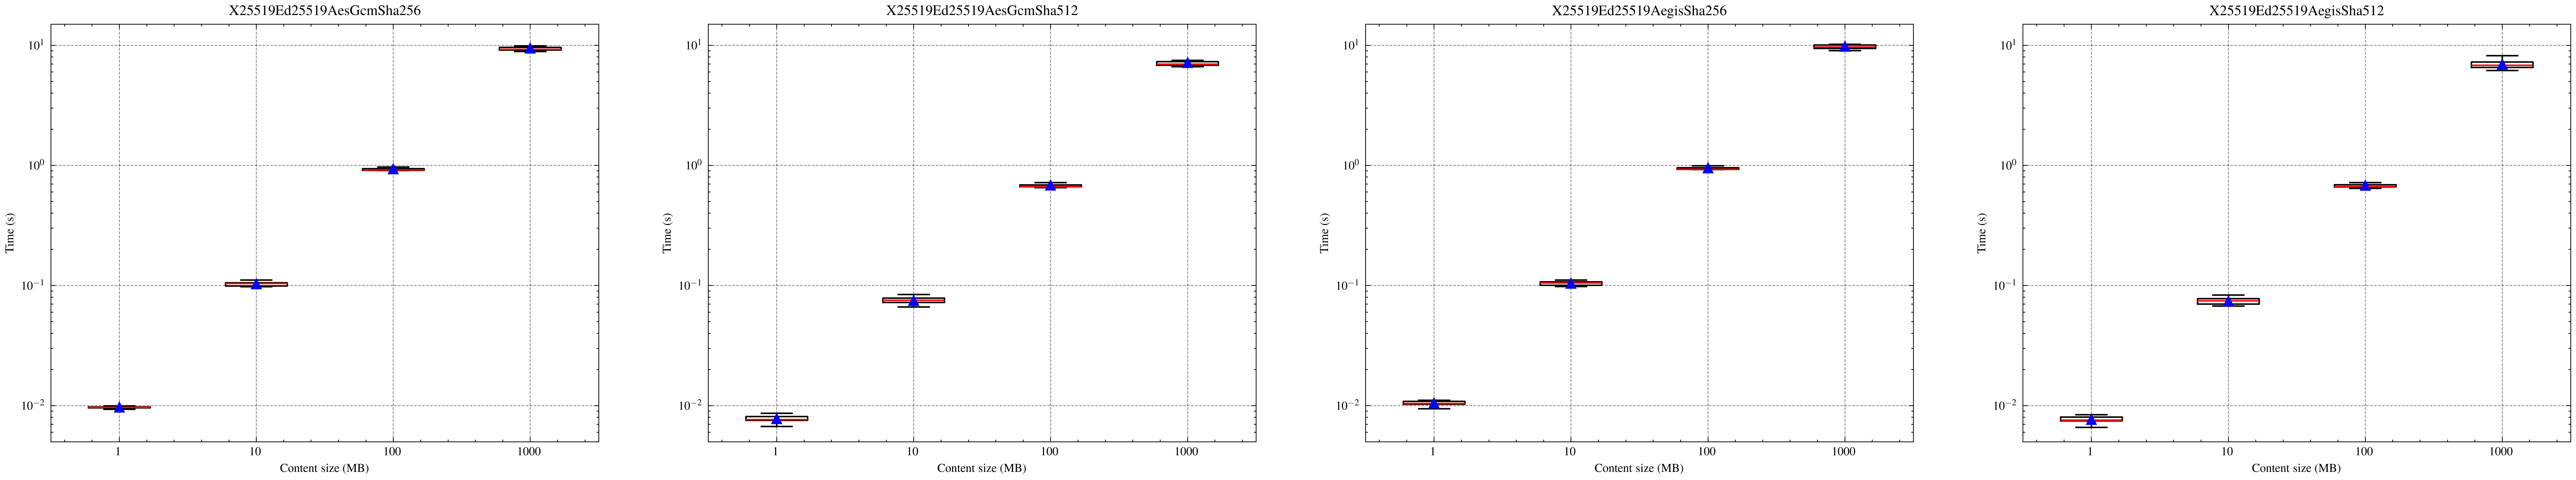

In [3]:
# Example plot
f, ax = plt.subplots(1, len(cipher_suites), figsize=(30, 5))
# compare cipher suites for different tests and runs
tests = ['Encrypt(1MB, n=5, True)', 'Encrypt(10MB, n=5, True)', 'Encrypt(100MB, n=5, True)', 'Encrypt(1000MB, n=5, True)']
data = {}
for test in tests:
    for cs in cipher_suites:
        if cs not in data:
            data[cs] = {}
        data[cs][test] = results[test]['Ryzen 7 7900X net8'][cs]
for a, (cs, test_data) in zip(ax.ravel(), data.items()):
    a.boxplot(test_data.values(), labels=[1, 10, 100, 1000], showfliers=False, showmeans=True, meanline=False, meanprops={'color': 'red', 'linewidth': 2})
    a.set_yscale('log')
    a.set_ylim(0.005, 15)
    a.set_ylabel('Time (s)')
    a.set_title(cs)
    a.set_xlabel('Content size (MB)')

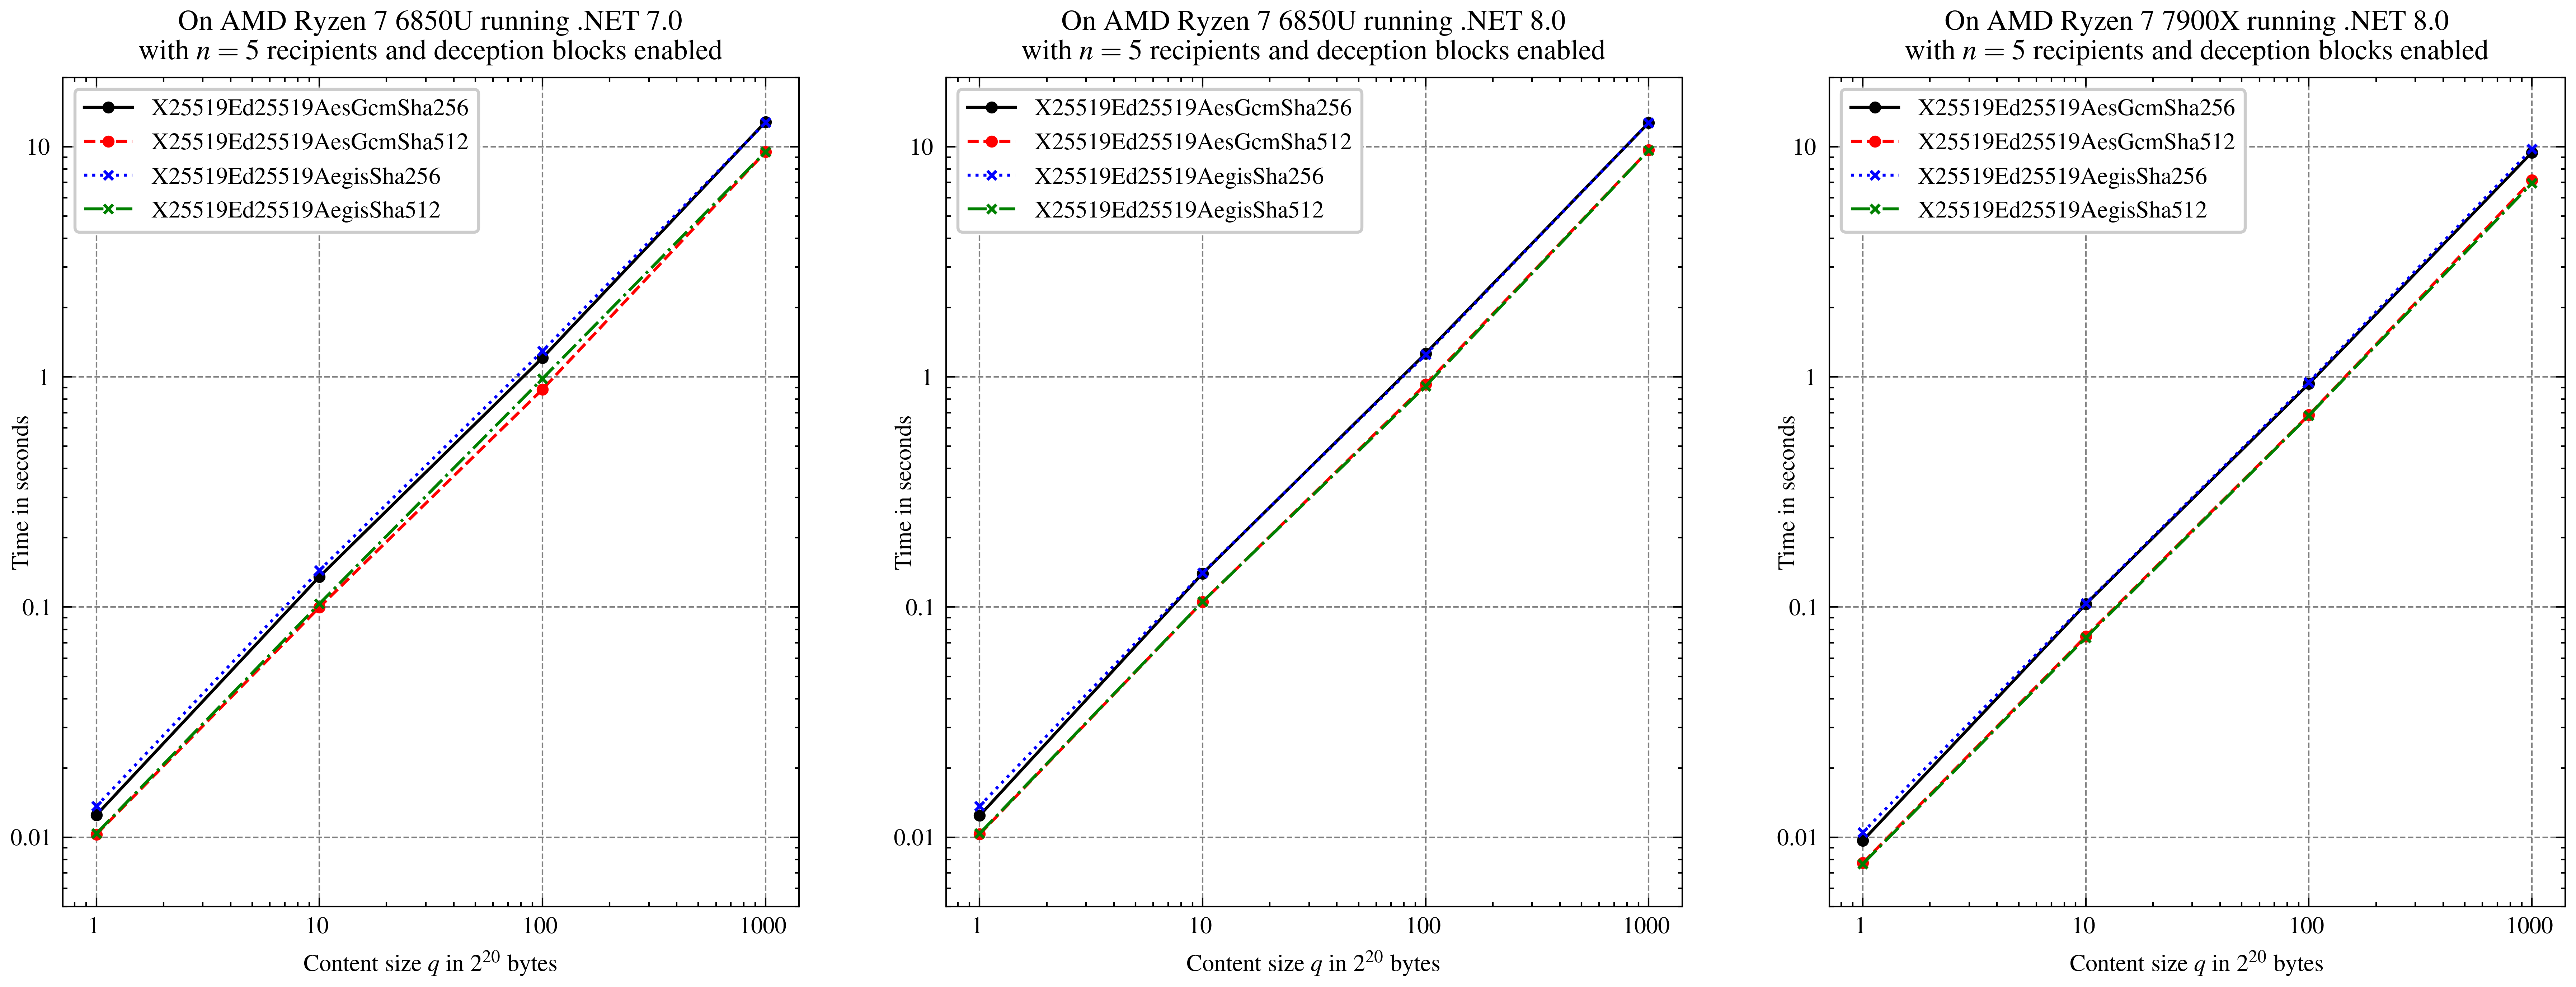

In [4]:
# Compare cipher suites for different content sizes
tests = ['Encrypt(1MB, n=5, True)', 'Encrypt(10MB, n=5, True)', 'Encrypt(100MB, n=5, True)', 'Encrypt(1000MB, n=5, True)']
f, ax = plt.subplots(1, len(performance_runs), figsize=(15, 5))
data = {}
for run in performance_runs:
    for test in tests:
        if run not in data:
            data[run] = {}
        data[run][test] = [results[test][run][cs].mean() for cs in cipher_suites]

dfs = {}
for a, (run, test_data) in zip(ax.ravel(), data.items()):
    df = pd.DataFrame(test_data, index=cipher_suites)
    df.columns = [1, 10, 100, 1000]
    for cs, m in zip(df.T.columns, ['o', 'o', 'x', 'x']):
        a.plot(df.T[cs], label=cs, marker=m, markersize=3)#, linestyle='--', linewidth=0.5)
    dfs[run] = df.T
    a.loglog()
    a.set_ylim(0.005, 20)
    a.set_ylabel('Time in seconds', labelpad=-7.5)
    a.set_title(f'On {get_run_friendly_name(run)}\nwith $n=5$ recipients and deception blocks enabled')
    a.set_xlabel('Content size $q$ in $2^{20}$ bytes')
    a.xaxis.set_major_formatter('{x:.0f}')
    a.yaxis.set_major_formatter('{x:.2n}')
    a.legend()

f.savefig('plots/content-size-encryption-times.pdf', bbox_inches='tight')

In [5]:
df_all = pd.concat([
    df.set_index([pd.MultiIndex.from_arrays([df.index, [get_run_table_name(run)] * len(df)])]) for run, df in dfs.items()
]).sort_index()
df_all.index = pd.MultiIndex.from_tuples([(f'\\qty{{{i}}}{{\\mebi\\byte}}', *a) for i, *a in df_all.index])
df_all.index.set_names(['Content Size', 'Run'], inplace=True)
df_all.columns = pd.MultiIndex.from_arrays([['Cipher Suite'] * 4, [f'\\multicolumn{{1}}{{c}}{{{get_cipher_suite_latex(c)}}}' for c in df_all.columns]])
df_all.to_latex(f'./data_processed/content size encrypt.tex',
                float_format='%.3f',
                escape=False,
                index_names=True,
                column_format='rcrrrr',
                multirow=True,
                multicolumn=True,
                multicolumn_format='c',
                bold_rows=False,
                sparsify=True)

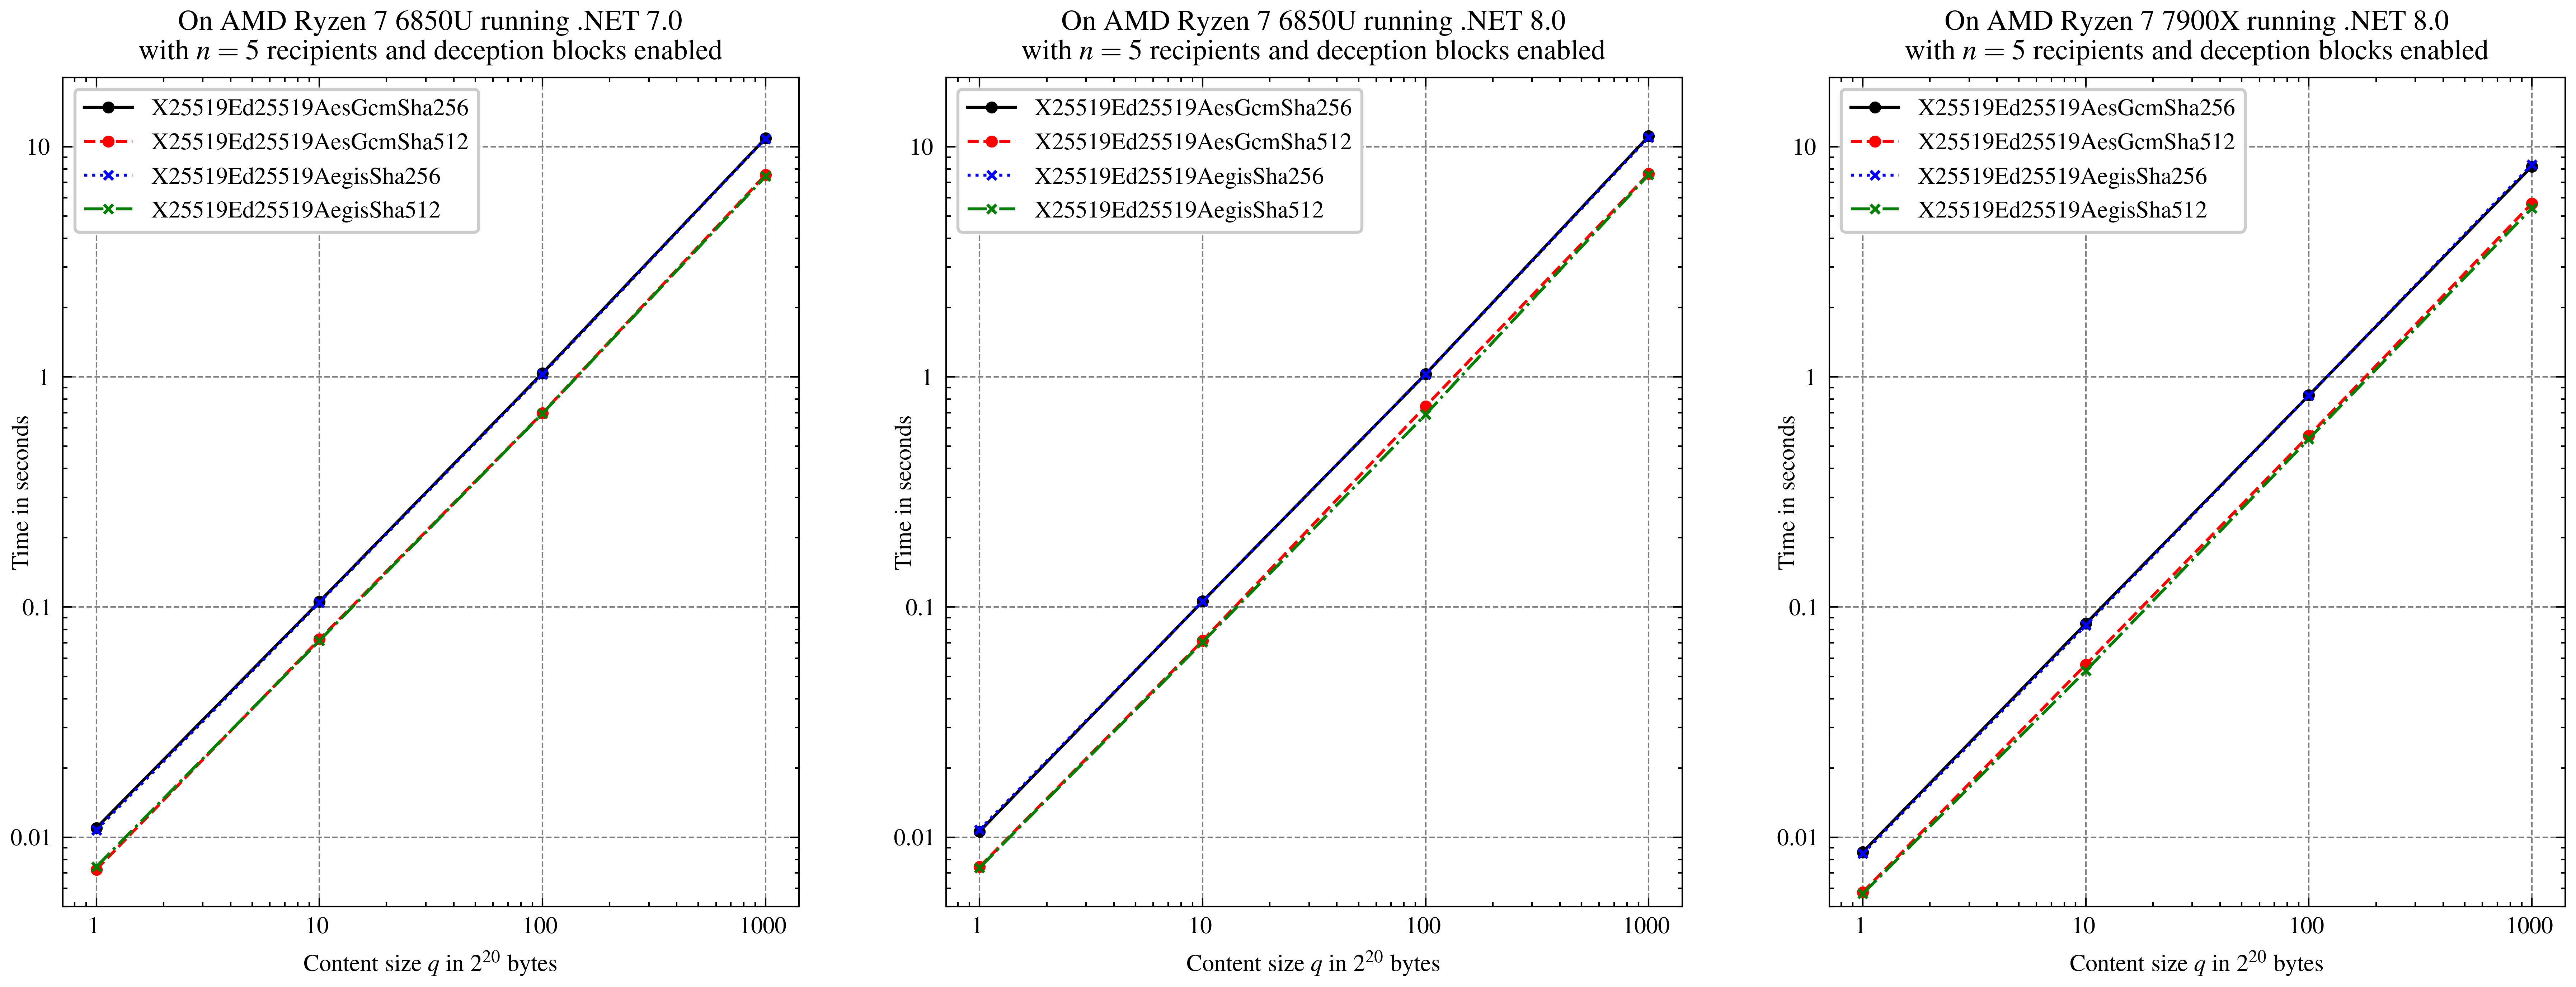

In [6]:
# Compare cipher suites for different content sizes
f, ax = plt.subplots(1, len(performance_runs), figsize=(15, 5))
tests = ['Decrypt(1MB, n=5, True, True)', 'Decrypt(10MB, n=5, True, True)', 'Decrypt(100MB, n=5, True, True)', 'Decrypt(1000MB, n=5, True, True)']
data = {}
for run in performance_runs:
    for test in tests:
        if run not in data:
            data[run] = {}
        data[run][test] = [results[test][run][cs].mean() for cs in cipher_suites]

dfs = {}
for a, (run, test_data) in zip(ax.ravel(), data.items()):
    df = pd.DataFrame(test_data, index=cipher_suites)
    df.columns = [1, 10, 100, 1000]
    for cs, m in zip(df.T.columns, ['o', 'o', 'x', 'x']):
        a.plot(df.T[cs], label=cs, marker=m, markersize=3)#, linestyle='--', linewidth=0.5)
    dfs[run] = df.T
    a.loglog()
    a.set_ylim(0.005, 20)
    a.set_ylabel('Time in seconds', labelpad=-7.5)
    a.set_title(f'On {get_run_friendly_name(run)}\nwith $n=5$ recipients and deception blocks enabled')
    a.set_xlabel('Content size $q$ in $2^{20}$ bytes')
    a.xaxis.set_major_formatter('{x:.0f}')
    a.yaxis.set_major_formatter('{x:.2n}')
    a.yaxis.grid(True)
    a.legend()

f.savefig('plots/content-size-decryption-times.pdf', bbox_inches='tight')

In [7]:
df_all = pd.concat([
    df.set_index([pd.MultiIndex.from_arrays([df.index, [get_run_table_name(run)] * len(df)])]) for run, df in dfs.items()
]).sort_index()
df_all.index = pd.MultiIndex.from_tuples([(f'\\qty{{{i}}}{{\\mebi\\byte}}', *a) for i, *a in df_all.index])
df_all.index.set_names(['Content Size', 'Run'], inplace=True)
df_all.columns = pd.MultiIndex.from_arrays([['Cipher Suite'] * 4, [f'\\multicolumn{{1}}{{c}}{{{get_cipher_suite_latex(c)}}}' for c in df_all.columns]])
df_all.to_latex(f'./data_processed/content size decrypt.tex',
                float_format='%.3f',
                escape=False,
                index_names=True,
                column_format='rcrrrr',
                multirow=True,
                multicolumn=True,
                multicolumn_format='c',
                bold_rows=False,
                sparsify=True)

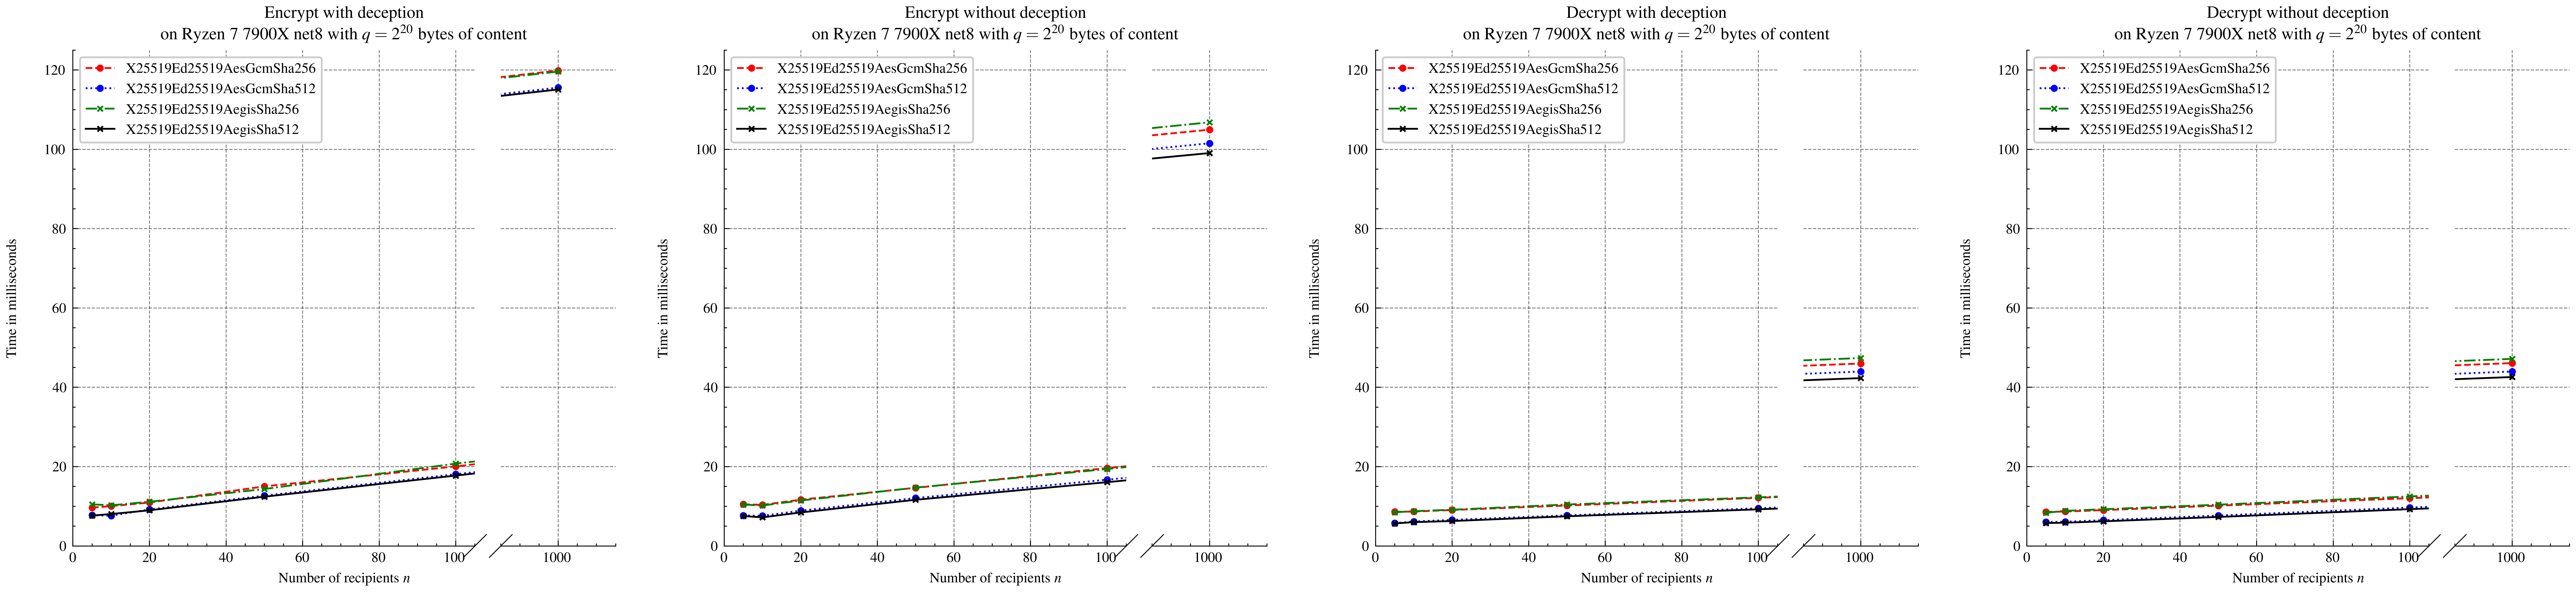

In [8]:
# Compare cipher suites for different number of recipients, 4-fold (Encrypt w/ Deception, Encrypt w/o Deception, Decrypt w/ Deception, Decrypt w/o Deception)
tests = {
    'E1': ['Encrypt(1MB, n=5, True)', 'Encrypt(1MB, n=10, True)', 'Encrypt(1MB, n=20, True)', 'Encrypt(1MB, n=50, True)', 'Encrypt(1MB, n=100, True)', 'Encrypt(1MB, n=1000, True)'],
    'E0': ['Encrypt(1MB, n=5, False)', 'Encrypt(1MB, n=10, False)', 'Encrypt(1MB, n=20, False)', 'Encrypt(1MB, n=50, False)', 'Encrypt(1MB, n=100, False)', 'Encrypt(1MB, n=1000, False)'],
    'D1': ['Decrypt(1MB, n=5, True, True)', 'Decrypt(1MB, n=10, True, True)', 'Decrypt(1MB, n=20, True, True)', 'Decrypt(1MB, n=50, True, True)', 'Decrypt(1MB, n=100, True, True)', 'Decrypt(1MB, n=1000, True, True)'],
    'D0': ['Decrypt(1MB, n=5, False, True)', 'Decrypt(1MB, n=10, False, True)', 'Decrypt(1MB, n=20, False, True)', 'Decrypt(1MB, n=50, False, True)', 'Decrypt(1MB, n=100, False, True)', 'Decrypt(1MB, n=1000, False, True)']
}
f = plt.figure(figsize=(25, 5))
run = 'Ryzen 7 7900X net8'
data = {}
for test_category in tests:
    if test_category not in data:
        data[test_category] = {}
    for test in tests[test_category]:
        data[test_category][test] = [results[test][run][cs].mean() \
                                     * 1000
                                     for cs in cipher_suites]
gs = plt.GridSpec(1, len(tests))
for gs, (test_category, test_data) in zip(gs, data.items()):
    df = pd.DataFrame(test_data, index=cipher_suites)
    df.columns = [5, 10, 20, 50, 100, 1000]
    bax = brokenaxes(
        #subplot_spec=a.get_subplotspec(),
        subplot_spec=gs,
        xlims=((0, 105), (985, 1015)),
        ylims=((0, 125),),
        hspace=.1,
        wspace=.1,
        d=0.005,
    )
    for cs, m in zip(df.T.columns, ['o', 'o', 'x', 'x']):
        bax.plot(df.T[cs], label=cs, marker=m, markersize=3)#, linestyle='--', linewidth=0.5)
    bax.set_ylabel('Time in milliseconds')
    bax.set_title({
        'E1': 'Encrypt with deception',
        'E0': 'Encrypt without deception',
        'D1': 'Decrypt with deception',
        'D0': 'Decrypt without deception',
    }[test_category] + f'\non {run} with $q = 2^{{20}}$ bytes of content')
    bax.set_xlabel('Number of recipients $n$')
    bax.grid(True)
    bax.legend(loc='upper left')

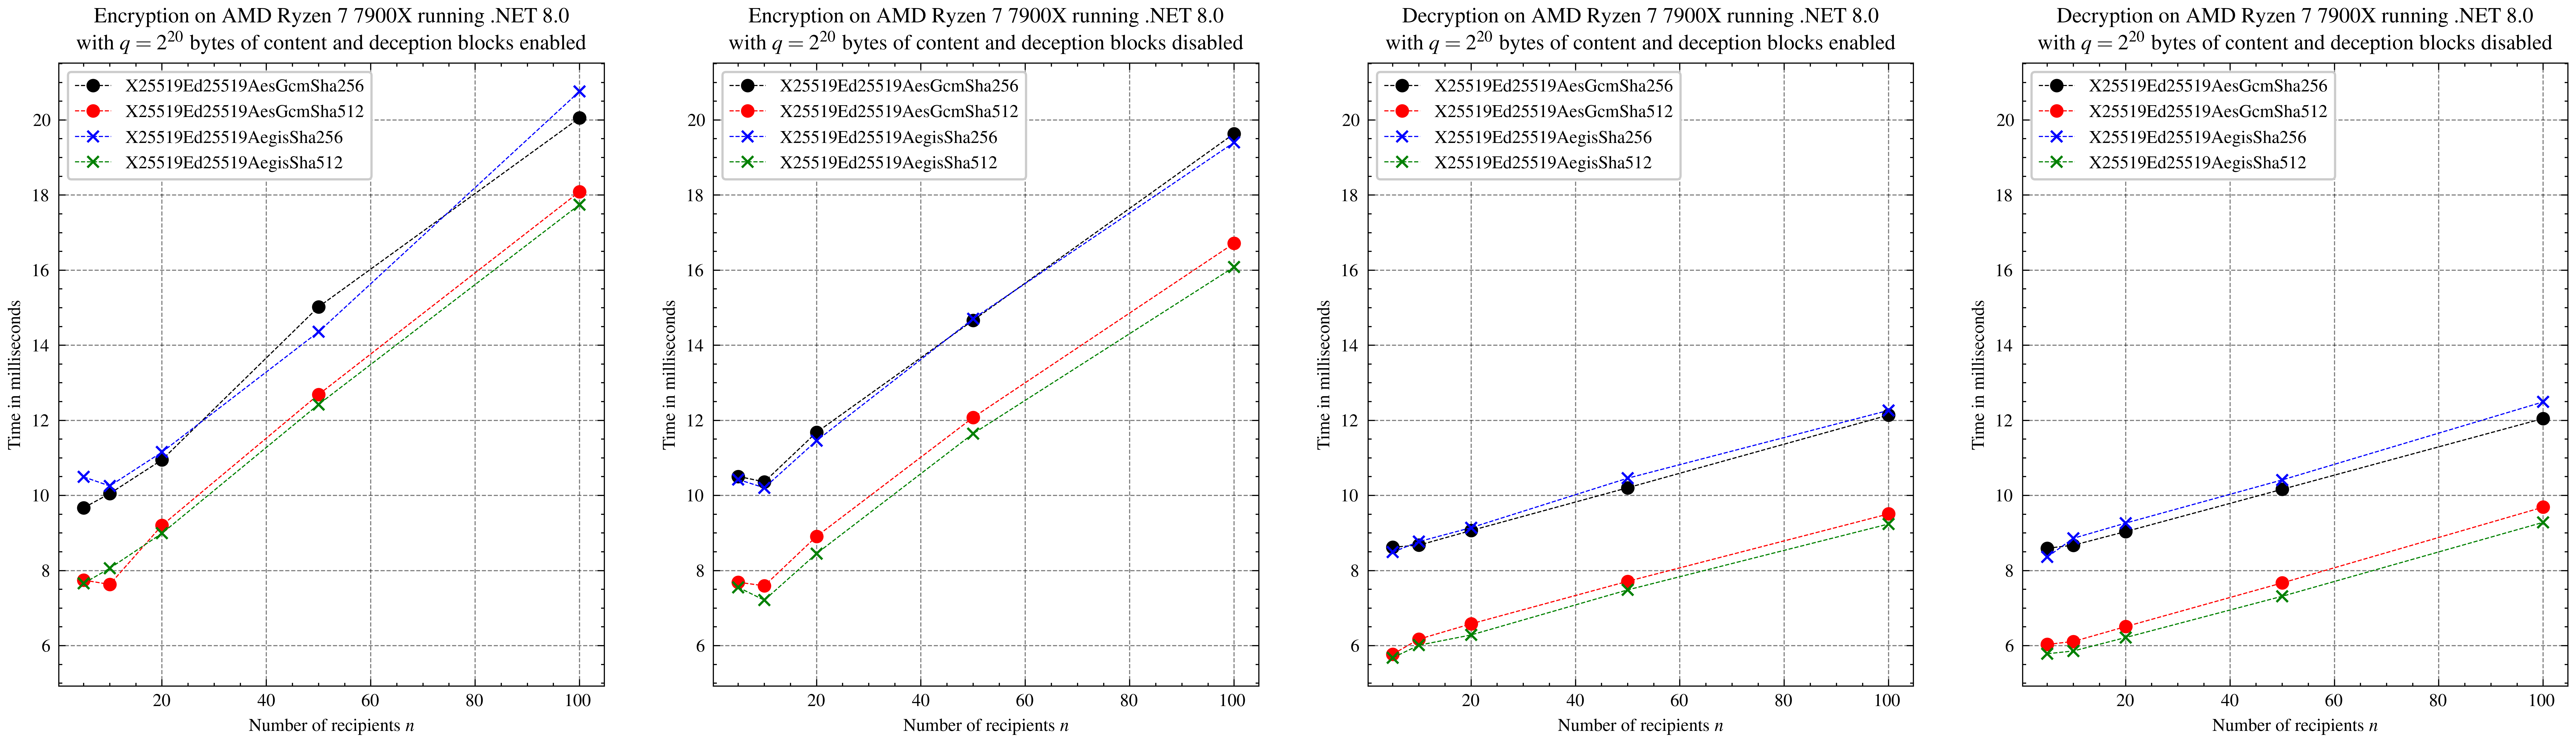

In [9]:
# Compare cipher suites for different number of recipients, 4-fold (Encrypt w/ Deception, Encrypt w/o Deception, Decrypt w/ Deception, Decrypt w/o Deception)
tests = {
    'E1': ['Encrypt(1MB, n=5, True)', 'Encrypt(1MB, n=10, True)', 'Encrypt(1MB, n=20, True)', 'Encrypt(1MB, n=50, True)', 'Encrypt(1MB, n=100, True)', 'Encrypt(1MB, n=1000, True)'],
    'E0': ['Encrypt(1MB, n=5, False)', 'Encrypt(1MB, n=10, False)', 'Encrypt(1MB, n=20, False)', 'Encrypt(1MB, n=50, False)', 'Encrypt(1MB, n=100, False)', 'Encrypt(1MB, n=1000, False)'],
    'D1': ['Decrypt(1MB, n=5, True, True)', 'Decrypt(1MB, n=10, True, True)', 'Decrypt(1MB, n=20, True, True)', 'Decrypt(1MB, n=50, True, True)', 'Decrypt(1MB, n=100, True, True)', 'Decrypt(1MB, n=1000, True, True)'],
    'D0': ['Decrypt(1MB, n=5, False, True)', 'Decrypt(1MB, n=10, False, True)', 'Decrypt(1MB, n=20, False, True)', 'Decrypt(1MB, n=50, False, True)', 'Decrypt(1MB, n=100, False, True)', 'Decrypt(1MB, n=1000, False, True)']
}
f, ax = plt.subplots(1, len(tests), figsize=(20, 5), sharey=True)
run = 'Ryzen 7 7900X net8'
data = {}
for test_category in tests:
    if test_category not in data:
        data[test_category] = {}
    for test in tests[test_category]:
        data[test_category][test] = [results[test][run][cs].mean() * 1000 \
                                     for cs in cipher_suites]

dfs = {}
for a, (test_category, test_data) in zip(ax.ravel(), data.items()):
    df = pd.DataFrame(test_data, index=cipher_suites)
    df.columns = [5, 10, 20, 50, 100, 1000]
    for cs, m in zip(df.T.columns, ['o', 'o', 'x', 'x']):
        a.plot(df.T[cs][:-1], marker=m, linestyle='--', label=cs, linewidth=0.5, markersize=5)
    dfs[test_category] = df.T
    #a.loglog()
    #a.set_ylim(0.005, 0.2)
    a.yaxis.set_tick_params(labelleft=True)
    a.set_ylabel('Time in milliseconds')
    a.set_title({
        'E1': 'Encryption',
        'E0': 'Encryption',
        'D1': 'Decryption',
        'D0': 'Decryption',
    }[test_category] + f' on {get_run_friendly_name(run)}\nwith $q = 2^{{20}}$ bytes of content and deception blocks ' + {
        'E1': 'enabled',
        'E0': 'disabled',
        'D1': 'enabled',
        'D0': 'disabled',
    }[test_category])
    a.set_xlabel('Number of recipients $n$')
    a.xaxis.set_major_formatter('{x:.0f}')
    a.yaxis.set_major_formatter('{x:.2n}')
    a.grid(True)
    a.legend(loc='upper left')

f.savefig('plots/number-of-recipients-times.pdf', bbox_inches='tight')

In [10]:
df_all = pd.concat([
    df.set_index([pd.MultiIndex.from_arrays(
        [df.index,
         [{
            'E1': r'$\encrypt$',
            'E0': r'$\encrypt$',
            'D1': r'$\decrypt$',
            'D0': r'$\decrypt$',
         }[test_category]] * len(df),
        [{
            'E1': r'\yes',
            'E0': r'\no',
            'D1': r'\yes',
            'D0': r'\no',
        }[test_category]] * len(df),
    ]),]) for test_category, df in dfs.items()
]).sort_index(ascending=[True, False, False])
df_all.index.set_names(['$n$', 'Action', 'Deception blocks'], inplace=True)
df_all.columns = pd.MultiIndex.from_arrays([['Cipher Suite'] * 4, [f'\\multicolumn{{1}}{{c}}{{{get_cipher_suite_latex(c)}}}' for c in df_all.columns]])
df_all.to_latex(f'./data_processed/number of recipients encdec.tex',
                float_format='%.3f',
                escape=False,
                index_names=True,
                column_format='rllrrrr',
                multirow=True,
                multicolumn=True,
                multicolumn_format='c',
                bold_rows=False,
                sparsify=True)

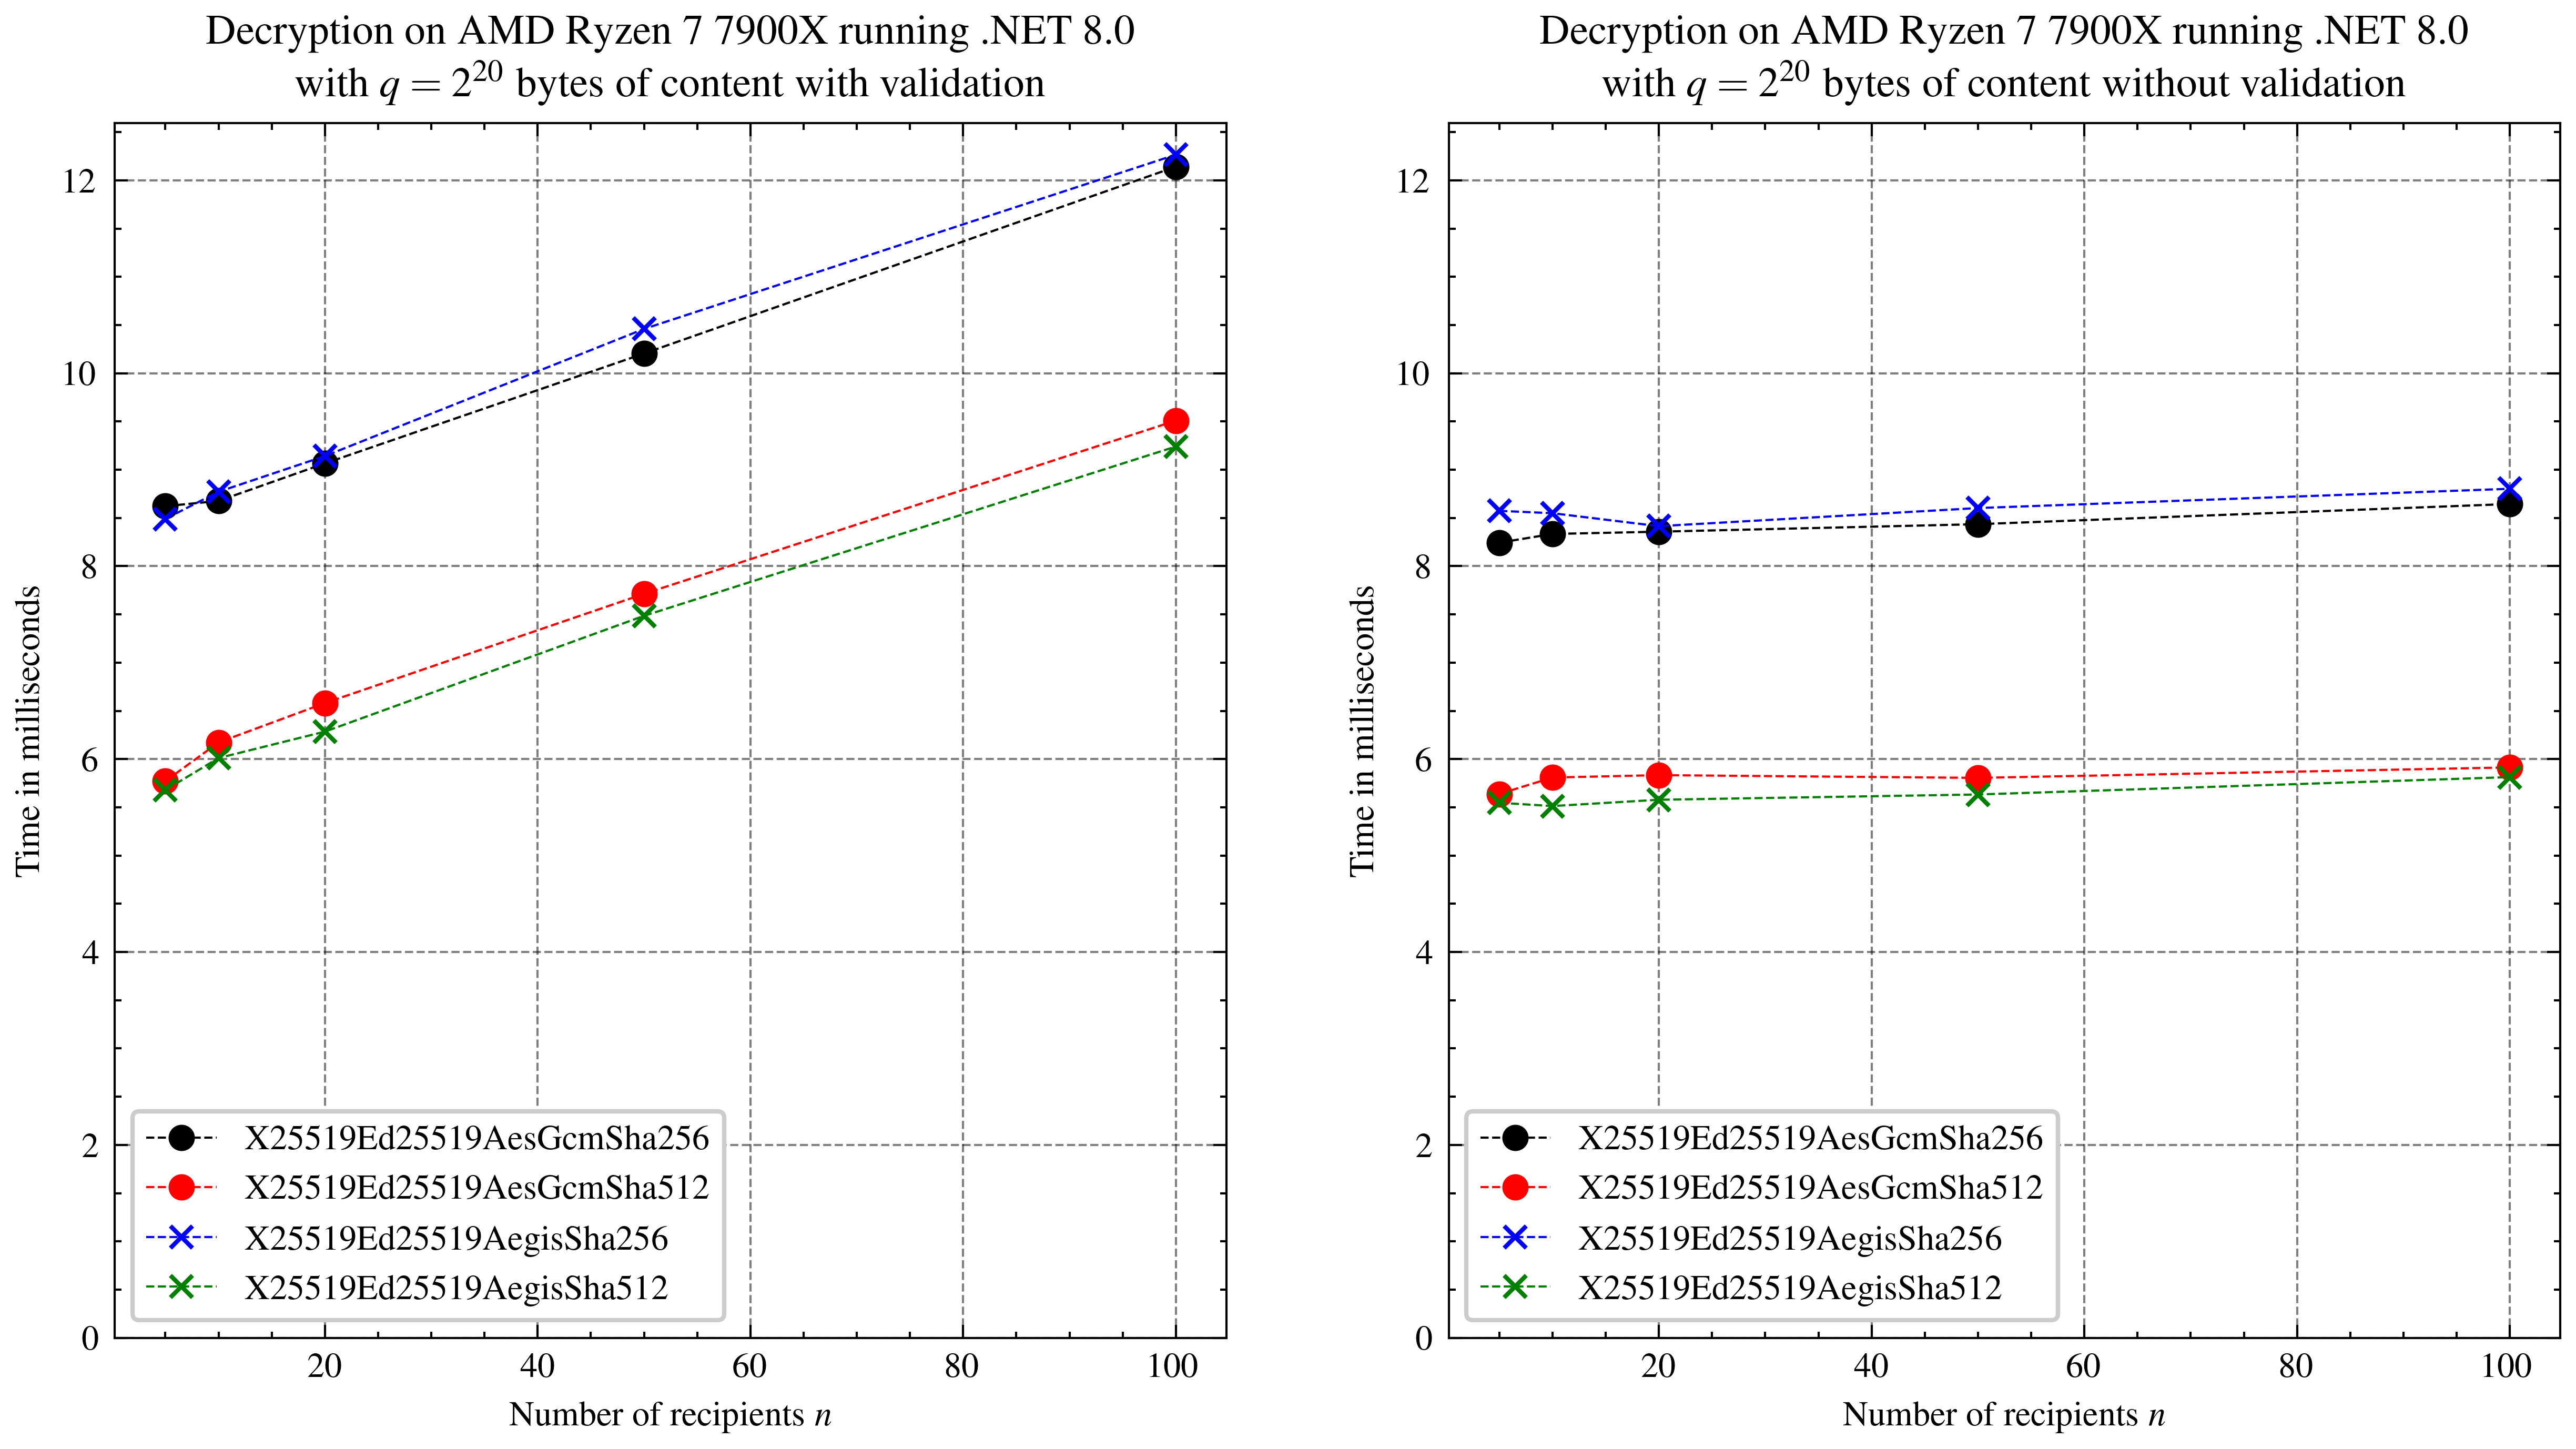

In [11]:
# Compare cipher suites for different number of recipients, 2-fold (Decrypt w/ Deception and Verify, Decrypt w/ Deception and No Verify)
tests = {
    'DV': ['Decrypt(1MB, n=5, True, True)', 'Decrypt(1MB, n=10, True, True)', 'Decrypt(1MB, n=20, True, True)', 'Decrypt(1MB, n=50, True, True)', 'Decrypt(1MB, n=100, True, True)', 'Decrypt(1MB, n=1000, True, True)'],
    'DU': ['Decrypt(1MB, n=5, True, False)', 'Decrypt(1MB, n=10, True, False)', 'Decrypt(1MB, n=20, True, False)', 'Decrypt(1MB, n=50, True, False)', 'Decrypt(1MB, n=100, True, False)', 'Decrypt(1MB, n=1000, True, False)']
}
f, ax = plt.subplots(1, len(tests), figsize=(10, 5), sharey=True)
run = 'Ryzen 7 7900X net8'
data = {}
for test_category in tests:
    if test_category not in data:
        data[test_category] = {}
    for test in tests[test_category]:
        data[test_category][test] = [results[test][run][cs].mean() \
                                     * 1000
                                     for cs in cipher_suites]

dfs = {}
for a, (test_category, test_data) in zip(ax.ravel(), data.items()):
    df = pd.DataFrame(test_data, index=cipher_suites)
    df.columns = [5, 10, 20, 50, 100, 1000]
    for cs, m in zip(df.T.columns, ['o', 'o', 'x', 'x']):
        a.plot(df.T[cs][:-1], marker=m, linestyle='--', label=cs, linewidth=0.5, markersize=5)
    dfs[test_category] = df.T
    a.set_ylabel('Time in milliseconds')
    a.set_title({
        'DV': 'Decryption',
        'DU': 'Decryption',
    }[test_category] + f' on {get_run_friendly_name(run)}\nwith $q = 2^{{20}}$ bytes of content ' + {
        'DV': 'with validation',
        'DU': 'without validation',
    }[test_category])
    a.set_xlabel('Number of recipients $n$')
    a.xaxis.set_major_formatter('{x:.0f}')
    a.yaxis.set_major_formatter('{x:.2n}')
    a.yaxis.set_tick_params(labelleft=True)
    a.set_ylim(bottom=0)
    a.grid(True)
    a.legend(loc='lower left')

f.savefig('plots/number-of-recipients-decryption-validation-times.pdf', bbox_inches='tight')

In [12]:
df_all = pd.concat([
    df.set_index([pd.MultiIndex.from_arrays([df.index, [{
        'DV': r'\yes',
        'DU': r'\no',
    }[test_category]] * len(df)])]) for test_category, df in dfs.items()
]).sort_index(ascending=[True, False])
df_all.index.set_names(['$n$', 'Validation'], inplace=True)
df_all.columns = pd.MultiIndex.from_arrays([['Cipher Suite'] * 4, [f'\\multicolumn{{1}}{{c}}{{{get_cipher_suite_latex(c)}}}' for c in df_all.columns]])
df_all.to_latex(f'./data_processed/decryption validation.tex',
                float_format='%.3f',
                escape=False,
                index_names=True,
                column_format='rcrrrr',
                multirow=True,
                multicolumn=True,
                multicolumn_format='c',
                bold_rows=False,
                sparsify=True)

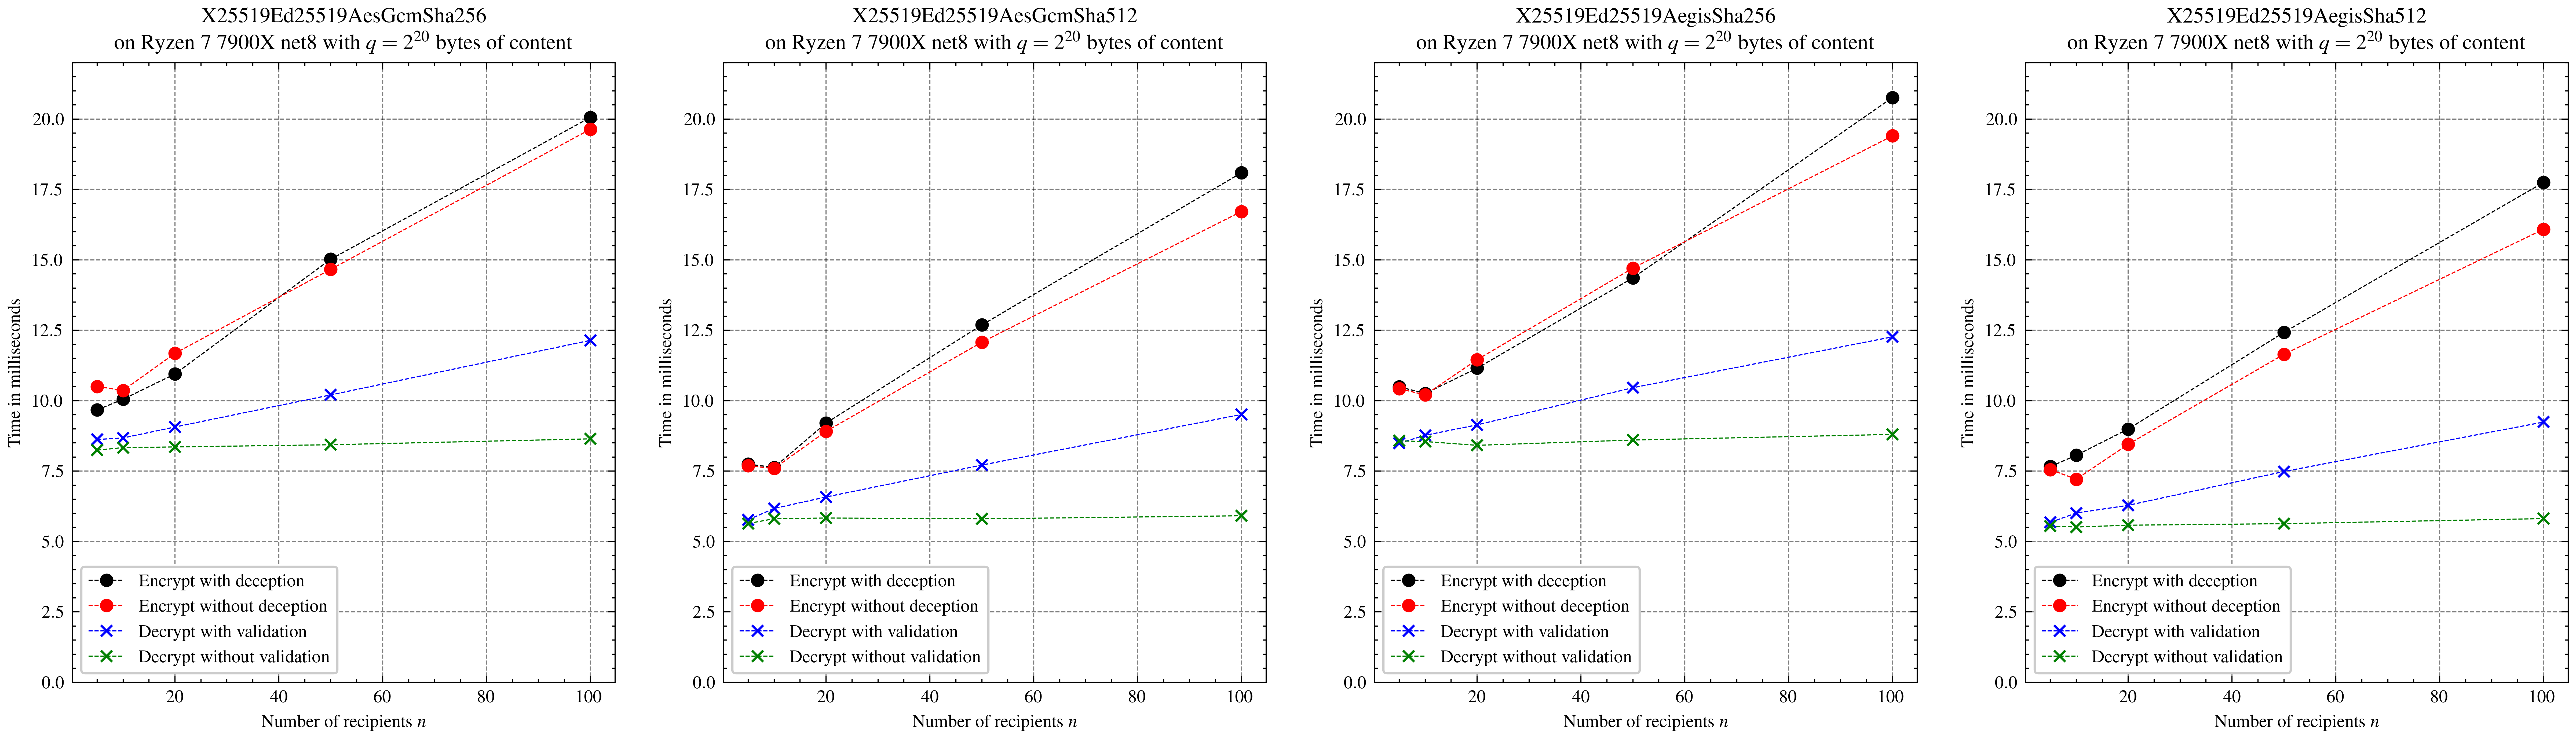

In [13]:
# Compare modes for different number of recipients
tests = {
    'ED': ['Encrypt(1MB, n=5, True)', 'Encrypt(1MB, n=10, True)', 'Encrypt(1MB, n=20, True)', 'Encrypt(1MB, n=50, True)', 'Encrypt(1MB, n=100, True)',],# 'Encrypt(1MB, n=1000, True)'],
    'EN': ['Encrypt(1MB, n=5, False)', 'Encrypt(1MB, n=10, False)', 'Encrypt(1MB, n=20, False)', 'Encrypt(1MB, n=50, False)', 'Encrypt(1MB, n=100, False)',],# 'Encrypt(1MB, n=1000, False)'],
    'DDV': ['Decrypt(1MB, n=5, True, True)', 'Decrypt(1MB, n=10, True, True)', 'Decrypt(1MB, n=20, True, True)', 'Decrypt(1MB, n=50, True, True)', 'Decrypt(1MB, n=100, True, True)',],# 'Decrypt(1MB, n=1000, True, True)'],
    #'DNV': ['Decrypt(1MB, n=5, False, True)', 'Decrypt(1MB, n=10, False, True)', 'Decrypt(1MB, n=20, False, True)', 'Decrypt(1MB, n=50, False, True)', 'Decrypt(1MB, n=100, False, True)',],# 'Decrypt(1MB, n=1000, False, True)'],
    'DDN': ['Decrypt(1MB, n=5, True, False)', 'Decrypt(1MB, n=10, True, False)', 'Decrypt(1MB, n=20, True, False)', 'Decrypt(1MB, n=50, True, False)', 'Decrypt(1MB, n=100, True, False)',],# 'Decrypt(1MB, n=1000, True, False)'],
}
f, ax = plt.subplots(1, len(cipher_suites), figsize=(20, 5), sharey=True)
run = 'Ryzen 7 7900X net8'
data = {}
for cs in cipher_suites:
    if cs not in data:
        data[cs] = {}
    for test_category in tests:
        data[cs][test_category] = [results[test][run][cs].mean() \
                                   * 1000
                                   for test in tests[test_category]]

for a, (cs, test_data) in zip(ax.ravel(), data.items()):
    df = pd.DataFrame(test_data, index=[5, 10, 20, 50, 100])#, 1000])
    for test_category, m in zip(df.columns, ['o', 'o', 'x', 'x', '.']):
        a.plot(df[test_category], marker=m, linestyle='--', label={
        'ED': 'Encrypt with deception',
        'EN': 'Encrypt without deception',
        'DDV': 'Decrypt with validation',
        'DNV': 'Decrypt with validation and without deception',
        'DDN': 'Decrypt without validation',
    }[test_category], linewidth=0.5, markersize=5)
    a.set_title(f'{cs}\non {run} with $q = 2^{{20}}$ bytes of content')
    a.set_ylabel('Time in milliseconds')
    a.set_xlabel('Number of recipients $n$')
    a.set_ylim(bottom=0, top=22)
    a.yaxis.set_tick_params(labelleft=True)
    a.grid(True)
    a.legend(loc='lower left')